In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import time

In [ ]:
# Ekstrak file ZIP
zip_path = '/content/dataset2.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'File berhasil diekstrak ke {extract_path}')

# Load model segmentasi
segmentation_model = tf.keras.models.load_model('/content/segmentasi_model_unet_best.h5')


File berhasil diekstrak ke /content/


In [ ]:
# Folder dataset
image_dir = '/content/dataset2'
segmented_dir = '/content/dataset2_segmented'
os.makedirs(segmented_dir, exist_ok=True)

SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH = 256, 256
PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH = 224, 224

# Data augmentation settings
data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [ ]:
def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH)) / 255.0
    image_input = np.expand_dims(image, axis=0)
    pred_mask = segmentation_model.predict(image_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    return pred_mask[:, :, 0]  # Mask biner

images = []
labels = []

In [ ]:
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(image_dir, filename)
        mask = segment_image(img_path)
        segmented_path = os.path.join(segmented_dir, filename)
        cv2.imwrite(segmented_path, mask * 255)

        # Load segmented image
        img_array = img_to_array(load_img(segmented_path, target_size=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH))) / 255.0
        label = int(filename.split('.')[0])

        # Tambahkan gambar asli
        images.append(img_array.astype(np.float32))
        labels.append(label)

        # Augmentasi sebanyak 3 kali
        img_array_expanded = np.expand_dims(img_array, axis=0)
        augmented_images = data_gen.flow(img_array_expanded, batch_size=1)

        for _ in range(2):
            aug_img = next(augmented_images)[0]  # Ambil batch pertama
            images.append(aug_img.astype(np.float32))
            labels.append(label)

X = np.array(images)
y = np.array(labels, dtype=np.float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load ResNet50 sebagai feature extractor
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)  # Dropout lebih tinggi untuk mencegah overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='linear')(x)  # Regresi

# Definisikan model
model = Model(inputs=base_model.input, outputs=output)

# Compile dengan Huber loss dan ReduceLROnPlateau
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=['mae']
)


# Print Model Summary
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,801,153 (94.61 MB)

 Trainable params: 1,213,441 (4.63 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Fungsi custom RMSE
def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    return tf.sqrt(tf.keras.backend.mean(tf.square(y_true - y_pred)))

# Compile model dengan RMSE
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae', rmse]
)

# Callback untuk menyimpan model terbaik
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Mulai hitung waktu training
start_time = time.time()

# Training model
history = model.fit(
    X, y,
    epochs=750,
    batch_size=32,
    callbacks=[checkpoint]
)

# Selesai hitung waktu training
end_time = time.time()
training_time = end_time - start_time
print(f"Waktu training: {training_time:.2f} detik")

Epoch 1/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 242319.5000 - mae: 439.0290 - rmse: 490.6794  
Epoch 1: loss improved from inf to 239285.35938, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - loss: 241308.1250 - mae: 438.4682 - rmse: 489.1077
Epoch 2/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 231968.6875 - mae: 430.5285 - rmse: 482.8704
Epoch 2: loss improved from 239285.35938 to 234447.67188, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 232795.0156 - mae: 430.9432 - rmse: 484.1356
Epoch 3/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 215571.6875 - mae: 414.8918 - rmse: 469.4482
Epoch 3: loss improved from 234447.67188 to 227579.01562, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 219574.1406 - mae: 417.7986 - rmse: 475.5576
Epoch 4/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 224232.0938 - mae: 419.0635 - rmse: 468.7715
Epoch 4: loss improved from 227579.01562 to 216178.37500, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 221547.5312 - mae: 415.9907 - rmse: 464.2991
Epoch 5/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 219353.6875 - mae: 404.7395 - rmse: 454.1710
Epoch 5: loss improved from 216178.37500 to 201069.37500, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 213258.9062 - mae: 399.6558 - rmse: 443.3529
Epoch 6/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 194373.0312 - mae: 377.5767 - rmse: 428.4712
Epoch 6: loss improved from 201069.37500 to 179274.07812, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 189340.0469 - mae: 371.6825 - rmse: 418.9911
Epoch 7/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 147025.1562 - mae: 320.0441 - rmse: 384.2068
Epoch 7: loss improved from 179274.07812 to 150634.01562, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 148228.1094 - mae: 319.2889 - rmse: 386.1684
Epoch 8/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 116411.8984 - mae: 262.1119 - rmse: 337.9185
Epoch 8: loss improved from 150634.01562 to 112848.00781, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 115223.9375 - mae: 259.9218 - rmse: 334.9781
Epoch 9/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 77822.3125 - mae: 184.0710 - rmse: 277.2447
Epoch 9: loss improved from 112848.00781 to 74425.02344, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 76689.8828 - mae: 182.7744 - rmse: 274.4556
Epoch 10/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 47629.8359 - mae: 153.0748 - rmse: 218.7882
Epoch 10: loss improved from 74425.02344 to 51590.75391, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 48950.1406 - mae: 157.6177 - rmse: 222.6637
Epoch 11/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 59050.4922 - mae: 214.6668 - rmse: 241.9058
Epoch 11: loss did not improve from 51590.75391
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 58243.1797 - mae: 213.7051 - rmse: 239.1036
Epoch 12/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 73566.6875 - mae: 243.7469 - rmse: 270.5604
Epoch 12: loss did not improve from 51590.75391
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 75118.5859 - mae: 246.8587 - rmse: 274.3604
Epoch 13/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 77948.8125 - mae: 254.2725 - rmse: 277.6558
Epoch 13: loss did not improve from 51590.75391
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 78198.1875 - mae: 255.2205 - rmse: 278.0553
Epoch 14/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 57293.9844 - mae: 217.9282 - rmse: 238.7294
Epoch 14: loss did not improve from 51590.75391
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 57813

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 46062.5938 - mae: 181.3582 - rmse: 224.1895
Epoch 16/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 41679.9961 - mae: 151.1859 - rmse: 202.2132
Epoch 16: loss did not improve from 44675.46875
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 46561.7852 - mae: 157.7515 - rmse: 217.0827
Epoch 17/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 50665.9297 - mae: 155.3329 - rmse: 226.6945
Epoch 17: loss did not improve from 44675.46875
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 52609.5703 - mae: 158.1519 - rmse: 232.7432
Epoch 18/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 55732.9492 - mae: 157.8061 - rmse: 238.9977
Epoch 18: loss did not improve from 44675.46875
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 55551.6641 - mae: 157.7118 - rmse: 238.7510
Epoch 19/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 70755.4844 - mae: 182.2588 - rmse: 241.9219
Epoch 19: loss did not improve from 44675.46875
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 67247.

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 41722.3945 - mae: 152.2735 - rmse: 225.8934
Epoch 32/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 54895.4375 - mae: 177.7417 - rmse: 229.4801
Epoch 32: loss did not improve from 43124.25391
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 53915.4648 - mae: 175.8593 - rmse: 227.1463
Epoch 33/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 51008.7188 - mae: 173.9717 - rmse: 224.1087
Epoch 33: loss did not improve from 43124.25391
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 51057.3906 - mae: 173.8044 - rmse: 223.3333
Epoch 34/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 51581.2266 - mae: 178.8193 - rmse: 226.7325
Epoch 34: loss did not improve from 43124.25391
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 50433.1680 - mae: 176.3548 - rmse: 223.1215
Epoch 35/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 40453.5938 - mae: 159.1994 - rmse: 222.1793
Epoch 35: loss improved from 43124.25391 to 42254.31250, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - loss: 41053.8320 - mae: 159.9991 - rmse: 223.8228
Epoch 36/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 48989.6250 - mae: 181.9684 - rmse: 227.3952  
Epoch 36: loss did not improve from 42254.31250
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - loss: 47638.9531 - mae: 177.8235 - rmse: 225.0621
Epoch 37/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 53400.1328 - mae: 183.5331 - rmse: 227.1714
Epoch 37: loss did not improve from 42254.31250
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 51887.7930 - mae: 181.4057 - rmse: 223.6038
Epoch 38/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 44732.3125 - mae: 170.9815 - rmse: 224.6067  
Epoch 38: loss did not improve from 42254.31250
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 45129.4688 - mae: 172.2437 - rmse: 225.6554
Epoch 39/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 51399.7188 - mae: 187.0110 - rmse: 226.4770
Epoch 39: loss did not improve from 42254.31250
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 5

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - loss: 38035.8594 - mae: 147.8803 - rmse: 224.7212
Epoch 44/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 45775.7734 - mae: 167.2281 - rmse: 222.7426
Epoch 44: loss did not improve from 39809.15234
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 46023.9805 - mae: 168.3947 - rmse: 224.2607
Epoch 45/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 40403.8086 - mae: 162.8201 - rmse: 219.2916
Epoch 45: loss did not improve from 39809.15234
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 41780.5430 - mae: 165.7892 - rmse: 221.7240
Epoch 46/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 45217.4805 - mae: 173.5504 - rmse: 226.7682
Epoch 46: loss did not improve from 39809.15234
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 44974.2383 - mae: 173.5246 - rmse: 225.1803
Epoch 47/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 45248.1602 - mae: 162.8158 - rmse: 228.9197
Epoch 47: loss did not improve from 39809.15234
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 44239

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 37928.8242 - mae: 154.7065 - rmse: 225.4102
Epoch 58/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 31416.7578 - mae: 147.3824 - rmse: 209.0296
Epoch 58: loss did not improve from 38006.21484
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 33898.5898 - mae: 152.3835 - rmse: 219.1468
Epoch 59/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 39994.5234 - mae: 164.3455 - rmse: 227.6437
Epoch 59: loss did not improve from 38006.21484
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 39816.5664 - mae: 163.4051 - rmse: 226.1291
Epoch 60/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 48094.6328 - mae: 177.7177 - rmse: 229.0140
Epoch 60: loss did not improve from 38006.21484
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 46781.6836 - mae: 174.3455 - rmse: 225.8833
Epoch 61/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 34034.8750 - mae: 150.1848 - rmse: 216.6159
Epoch 61: loss improved from 38006.21484 to 37736.34766, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 35268.6992 - mae: 152.4621 - rmse: 222.0436
Epoch 62/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 41853.5000 - mae: 154.9295 - rmse: 229.1725
Epoch 62: loss did not improve from 37736.34766
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 41490.8477 - mae: 154.8085 - rmse: 225.6610
Epoch 63/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 44816.4141 - mae: 156.8010 - rmse: 226.8030
Epoch 63: loss did not improve from 37736.34766
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 44236.0586 - mae: 156.0488 - rmse: 223.4965
Epoch 64/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 35962.8477 - mae: 144.3809 - rmse: 216.7369
Epoch 64: loss did not improve from 37736.34766
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 37851.3242 - mae: 148.1202 - rmse: 222.3717
Epoch 65/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 41462.4062 - mae: 159.9986 - rmse: 216.8892
Epoch 65: loss did not improve from 37736.34766
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 42840.

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 34210.2656 - mae: 151.1388 - rmse: 224.3104
Epoch 68/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 38488.9844 - mae: 162.7402 - rmse: 229.8526
Epoch 68: loss did not improve from 36154.40234
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 37749.7812 - mae: 161.7563 - rmse: 226.0927
Epoch 69/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 36947.9141 - mae: 158.3542 - rmse: 228.8114
Epoch 69: loss did not improve from 36154.40234
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 37448.4102 - mae: 159.2257 - rmse: 231.9872
Epoch 70/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 39482.7812 - mae: 160.4512 - rmse: 227.3067
Epoch 70: loss did not improve from 36154.40234
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 39844.5000 - mae: 161.4287 - rmse: 230.0590
Epoch 71/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 38297.4023 - mae: 163.3135 - rmse: 226.7282
Epoch 71: loss did not improve from 36154.40234
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 38376

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 34787.6289 - mae: 146.2710 - rmse: 226.4969
Epoch 73/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 35711.0078 - mae: 140.3376 - rmse: 232.5108
Epoch 73: loss did not improve from 34202.44922
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 35616.3945 - mae: 142.1249 - rmse: 232.4132
Epoch 74/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 37003.5508 - mae: 145.1153 - rmse: 230.9980
Epoch 74: loss did not improve from 34202.44922
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 36156.9023 - mae: 142.8087 - rmse: 225.9741
Epoch 75/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 23997.1387 - mae: 120.4035 - rmse: 196.4688
Epoch 75: loss improved from 34202.44922 to 33132.45703, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 27042.2441 - mae: 126.8015 - rmse: 210.7563
Epoch 76/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 37881.5625 - mae: 148.9490 - rmse: 226.9937
Epoch 76: loss did not improve from 33132.45703
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 37625.8320 - mae: 148.3938 - rmse: 227.5529
Epoch 77/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 40816.6641 - mae: 152.2618 - rmse: 240.7748
Epoch 77: loss did not improve from 33132.45703
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 40257.2461 - mae: 152.1288 - rmse: 236.6002
Epoch 78/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 36819.5781 - mae: 145.9053 - rmse: 228.3789
Epoch 78: loss did not improve from 33132.45703
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 36258.7852 - mae: 144.7237 - rmse: 226.3230
Epoch 79/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 32026.1055 - mae: 141.8367 - rmse: 234.9117
Epoch 79: loss improved from 33132.45703 to 32810.53516, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 32287.5820 - mae: 141.7054 - rmse: 235.3239
Epoch 80/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 32699.7324 - mae: 140.0490 - rmse: 231.2315
Epoch 80: loss did not improve from 32810.53516
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 33370.0078 - mae: 142.0995 - rmse: 231.4627
Epoch 81/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 27371.5000 - mae: 124.6690 - rmse: 218.2431
Epoch 81: loss improved from 32810.53516 to 28645.67188, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 27796.2246 - mae: 126.7305 - rmse: 224.8078
Epoch 82/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 34308.9688 - mae: 142.9794 - rmse: 240.3628
Epoch 82: loss did not improve from 28645.67188
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 33745.4102 - mae: 141.4431 - rmse: 236.2520
Epoch 83/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 35754.7812 - mae: 151.8472 - rmse: 238.5717
Epoch 83: loss did not improve from 28645.67188
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 35692.3594 - mae: 150.6556 - rmse: 234.4194
Epoch 84/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 35648.6914 - mae: 145.8320 - rmse: 233.2140
Epoch 84: loss did not improve from 28645.67188
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 35395.6797 - mae: 145.8074 - rmse: 227.9739
Epoch 85/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 34408.0859 - mae: 144.1042 - rmse: 232.0706
Epoch 85: loss did not improve from 28645.67188
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 34533.

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 31145.3516 - mae: 137.8723 - rmse: 212.8156
Epoch 88/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 29702.1934 - mae: 131.5793 - rmse: 241.7157
Epoch 88: loss did not improve from 28158.61914
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 29375.8145 - mae: 129.8967 - rmse: 243.5234
Epoch 89/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 31680.3633 - mae: 126.9005 - rmse: 242.7205
Epoch 89: loss did not improve from 28158.61914
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 31383.7930 - mae: 126.9251 - rmse: 238.6267
Epoch 90/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 29837.8984 - mae: 135.4381 - rmse: 242.1241
Epoch 90: loss did not improve from 28158.61914
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 29322.7305 - mae: 134.2268 - rmse: 240.3881
Epoch 91/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 31917.3184 - mae: 133.1939 - rmse: 239.0725
Epoch 91: loss did not improve from 28158.61914
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 31931.

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 24657.3223 - mae: 117.9600 - rmse: 241.9828
Epoch 93/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 32172.5547 - mae: 142.9202 - rmse: 233.8374
Epoch 93: loss did not improve from 25400.07812
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 31625.9199 - mae: 141.6274 - rmse: 239.0411
Epoch 94/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 23477.4492 - mae: 113.6132 - rmse: 255.8970
Epoch 94: loss improved from 25400.07812 to 25034.95898, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 23996.6191 - mae: 116.1460 - rmse: 251.8255
Epoch 95/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 27373.8125 - mae: 124.5534 - rmse: 239.2855
Epoch 95: loss did not improve from 25034.95898
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 27782.9863 - mae: 125.6151 - rmse: 240.8774
Epoch 96/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 29337.5625 - mae: 136.4395 - rmse: 239.0512
Epoch 96: loss did not improve from 25034.95898
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 29203.3828 - mae: 135.8226 - rmse: 244.5249
Epoch 97/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 25893.7285 - mae: 120.8436 - rmse: 246.0557
Epoch 97: loss did not improve from 25034.95898
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 26046.4688 - mae: 120.3351 - rmse: 247.8536
Epoch 98/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 22643.3320 - mae: 115.9011 - rmse: 251.4773
Epoch 98: loss improved from 25034.95898 to 24082.50781, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 23123.0566 - mae: 117.4573 - rmse: 249.3379
Epoch 99/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 25711.1914 - mae: 127.1452 - rmse: 252.4058  
Epoch 99: loss did not improve from 24082.50781
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 25259.9629 - mae: 125.5499 - rmse: 247.3605
Epoch 100/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 24127.0547 - mae: 126.5514 - rmse: 253.4503  
Epoch 100: loss improved from 24082.50781 to 21414.21289, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - loss: 23222.7754 - mae: 123.5231 - rmse: 244.7538
Epoch 101/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 26859.1016 - mae: 122.7461 - rmse: 252.1173
Epoch 101: loss did not improve from 21414.21289
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 27140.3613 - mae: 123.5415 - rmse: 249.2652
Epoch 102/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 24479.7383 - mae: 122.1943 - rmse: 254.7925
Epoch 102: loss did not improve from 21414.21289
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 24224.2578 - mae: 121.2902 - rmse: 250.3285
Epoch 103/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 24553.1992 - mae: 115.6411 - rmse: 250.0580
Epoch 103: loss did not improve from 21414.21289
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 25174.8477 - mae: 117.3792 - rmse: 252.0504
Epoch 104/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 20847.7363 - mae: 111.9376 - rmse: 249.7825
Epoch 104: loss improved from 21414.21289 to 19932.51758, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 20542.6641 - mae: 111.5229 - rmse: 255.7206
Epoch 105/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 20692.0430 - mae: 112.2885 - rmse: 254.2556
Epoch 105: loss did not improve from 19932.51758
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 21045.7344 - mae: 112.4619 - rmse: 254.0761
Epoch 106/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 26121.3359 - mae: 115.1060 - rmse: 253.1741
Epoch 106: loss did not improve from 19932.51758
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 26113.7090 - mae: 116.4487 - rmse: 258.7409
Epoch 107/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 22313.5977 - mae: 117.1472 - rmse: 254.6233
Epoch 107: loss did not improve from 19932.51758
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 21646.3848 - mae: 114.8714 - rmse: 259.8182
Epoch 108/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 19182.4902 - mae: 100.6909 - rmse: 250.8468
Epoch 108: loss did not improve from 19932.51758
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - lo

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - loss: 19408.6465 - mae: 108.0894 - rmse: 267.9264
Epoch 110/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 18632.1309 - mae: 105.2213 - rmse: 257.8052
Epoch 110: loss did not improve from 18253.11719
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 18735.3184 - mae: 106.1148 - rmse: 263.2945
Epoch 111/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 20799.2773 - mae: 112.4911 - rmse: 255.3860
Epoch 111: loss did not improve from 18253.11719
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 20558.2266 - mae: 112.6777 - rmse: 263.3632
Epoch 112/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 17637.4453 - mae: 97.5441 - rmse: 253.7593
Epoch 112: loss improved from 18253.11719 to 17952.42969, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 17742.4414 - mae: 98.4860 - rmse: 252.5319
Epoch 113/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 18589.0430 - mae: 105.7318 - rmse: 258.4265
Epoch 113: loss did not improve from 17952.42969
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 19169.1914 - mae: 107.5575 - rmse: 264.4872
Epoch 114/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 17998.1445 - mae: 105.3004 - rmse: 274.6534
Epoch 114: loss improved from 17952.42969 to 17173.57617, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 17723.2871 - mae: 104.2640 - rmse: 273.0252
Epoch 115/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 15292.6738 - mae: 98.5285 - rmse: 282.9992
Epoch 115: loss improved from 17173.57617 to 16925.50000, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 15836.9492 - mae: 98.7289 - rmse: 278.1411
Epoch 116/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 17146.1738 - mae: 101.8128 - rmse: 270.5269
Epoch 116: loss improved from 16925.50000 to 16607.43164, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 16966.5938 - mae: 100.7373 - rmse: 265.6000
Epoch 117/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 19202.5312 - mae: 104.8324 - rmse: 266.4979
Epoch 117: loss did not improve from 16607.43164
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 19057.7949 - mae: 104.3200 - rmse: 263.5538
Epoch 118/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 18068.7305 - mae: 100.5694 - rmse: 267.3905
Epoch 118: loss did not improve from 16607.43164
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 17917.6621 - mae: 100.5120 - rmse: 267.0469
Epoch 119/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 16861.1758 - mae: 102.2838 - rmse: 271.5629
Epoch 119: loss did not improve from 16607.43164
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 17345.2012 - mae: 104.2258 - rmse: 269.1616
Epoch 120/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 19015.4414 - mae: 106.6795 - rmse: 263.9252
Epoch 120: loss did not improve from 16607.43164
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - los

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 14721.8896 - mae: 91.3277 - rmse: 273.1929
Epoch 124/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 16198.9346 - mae: 98.2702 - rmse: 278.2661
Epoch 124: loss did not improve from 15683.20605
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 16631.4707 - mae: 98.6525 - rmse: 274.8747
Epoch 125/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 18080.2305 - mae: 100.5480 - rmse: 279.2690
Epoch 125: loss did not improve from 15683.20605
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 18135.5723 - mae: 101.1529 - rmse: 274.5660
Epoch 126/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 13231.6758 - mae: 85.1090 - rmse: 265.4172
Epoch 126: loss improved from 15683.20605 to 14719.34863, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 13727.5664 - mae: 86.8113 - rmse: 270.5951
Epoch 127/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 13557.6650 - mae: 91.5889 - rmse: 280.4364
Epoch 127: loss did not improve from 14719.34863
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 14242.3467 - mae: 92.7290 - rmse: 276.4064
Epoch 128/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 12713.3535 - mae: 85.5821 - rmse: 284.8856
Epoch 128: loss improved from 14719.34863 to 14555.10547, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 13327.2705 - mae: 86.4048 - rmse: 279.4019
Epoch 129/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 12440.7559 - mae: 87.9067 - rmse: 272.2604
Epoch 129: loss improved from 14555.10547 to 12223.92676, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 12368.4795 - mae: 87.6369 - rmse: 275.7922
Epoch 130/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 12224.0840 - mae: 87.8378 - rmse: 285.6243
Epoch 130: loss did not improve from 12223.92676
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 12287.5654 - mae: 88.1830 - rmse: 284.0471
Epoch 131/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 11591.6270 - mae: 79.2554 - rmse: 285.0975
Epoch 131: loss did not improve from 12223.92676
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 12221.1182 - mae: 81.4514 - rmse: 278.1022
Epoch 132/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 13825.1094 - mae: 96.8484 - rmse: 280.5596
Epoch 132: loss did not improve from 12223.92676
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 13957.0986 - mae: 96.9062 - rmse: 271.7776
Epoch 133/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 10100.3906 - mae: 78.5549 - rmse: 285.9431
Epoch 133: loss improved from 12223.92676 to 11304.25000, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 10501.6777 - mae: 79.3187 - rmse: 273.8319
Epoch 134/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 10976.2822 - mae: 81.8253 - rmse: 250.6683
Epoch 134: loss did not improve from 11304.25000
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 11941.3203 - mae: 84.9669 - rmse: 260.4328
Epoch 135/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 13497.9473 - mae: 86.8867 - rmse: 281.8744
Epoch 135: loss did not improve from 11304.25000
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 13410.9619 - mae: 86.2434 - rmse: 273.2656
Epoch 136/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 13599.8457 - mae: 83.8588 - rmse: 274.2620
Epoch 136: loss did not improve from 11304.25000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 13541.8818 - mae: 82.8426 - rmse: 272.2081
Epoch 137/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 12424.9961 - mae: 83.6019 - rmse: 274.7378
Epoch 137: loss did not improve from 11304.25000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 12458

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 10277.1660 - mae: 75.4655 - rmse: 282.3194
Epoch 147/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 10324.9629 - mae: 79.8637 - rmse: 291.0485
Epoch 147: loss improved from 10019.51855 to 9675.30176, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 10108.4092 - mae: 79.2420 - rmse: 289.1483
Epoch 148/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 10925.0742 - mae: 80.1137 - rmse: 278.8475
Epoch 148: loss did not improve from 9675.30176
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 11355.5537 - mae: 80.7266 - rmse: 280.3818
Epoch 149/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 10418.0664 - mae: 72.1716 - rmse: 273.2690
Epoch 149: loss improved from 9675.30176 to 9008.57617, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 9948.2363 - mae: 69.9789 - rmse: 279.1786
Epoch 150/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 12992.4092 - mae: 78.6023 - rmse: 286.3161
Epoch 150: loss did not improve from 9008.57617
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 13192.6934 - mae: 79.4233 - rmse: 285.6183
Epoch 151/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 8127.3481 - mae: 72.8403 - rmse: 274.4963
Epoch 151: loss did not improve from 9008.57617
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 8640.2432 - mae: 74.7258 - rmse: 276.9089
Epoch 152/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 8172.5938 - mae: 64.0861 - rmse: 282.8636
Epoch 152: loss improved from 9008.57617 to 8815.60449, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 8386.9307 - mae: 64.8570 - rmse: 288.0578
Epoch 153/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 10078.5566 - mae: 70.1947 - rmse: 271.1637
Epoch 153: loss did not improve from 8815.60449
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 9670.6807 - mae: 69.1267 - rmse: 279.5121 
Epoch 154/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 8893.8945 - mae: 71.3332 - rmse: 278.7861
Epoch 154: loss improved from 8815.60449 to 8392.73535, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 8726.8418 - mae: 70.4494 - rmse: 281.5480
Epoch 155/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 10690.2734 - mae: 75.6796 - rmse: 259.1767
Epoch 155: loss did not improve from 8392.73535
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 10809.5020 - mae: 76.2239 - rmse: 268.6151
Epoch 156/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 6628.1621 - mae: 66.3340 - rmse: 275.4560
Epoch 156: loss improved from 8392.73535 to 7673.76123, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 6976.6948 - mae: 67.2522 - rmse: 278.3031
Epoch 157/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 10626.3535 - mae: 73.8445 - rmse: 284.0812
Epoch 157: loss did not improve from 7673.76123
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 10628.0938 - mae: 74.3825 - rmse: 283.2472
Epoch 158/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 7061.4272 - mae: 61.6300 - rmse: 308.1659
Epoch 158: loss did not improve from 7673.76123
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 7347.8809 - mae: 63.1743 - rmse: 302.3887
Epoch 159/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 8287.4082 - mae: 70.3931 - rmse: 281.4409
Epoch 159: loss did not improve from 7673.76123
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 8594.9512 - mae: 70.6611 - rmse: 285.9688
Epoch 160/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 7609.6279 - mae: 65.6880 - rmse: 261.2606  
Epoch 160: loss did not improve from 7673.76123
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - loss: 7734.4082 - m

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 5172.7705 - mae: 57.2139 - rmse: 288.8862
Epoch 163/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 12098.3867 - mae: 79.1717 - rmse: 284.8314  
Epoch 163: loss did not improve from 5423.25244
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - loss: 11543.9814 - mae: 76.8179 - rmse: 284.2234
Epoch 164/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 10054.8535 - mae: 82.2806 - rmse: 309.4449
Epoch 164: loss did not improve from 5423.25244
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 9791.5586 - mae: 80.9773 - rmse: 307.7596
Epoch 165/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 7109.1553 - mae: 60.3081 - rmse: 292.7161
Epoch 165: loss did not improve from 5423.25244
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 7313.3662 - mae: 61.7274 - rmse: 292.4536
Epoch 166/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 9062.6885 - mae: 71.7944 - rmse: 280.7236 
Epoch 166: loss did not improve from 5423.25244
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 8737.7324 

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step - loss: 5308.3037 - mae: 53.9658 - rmse: 295.5304
Epoch 175/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 6705.9404 - mae: 66.7891 - rmse: 276.7205
Epoch 175: loss did not improve from 5247.45752
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 6639.1050 - mae: 66.1807 - rmse: 285.8423
Epoch 176/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 8757.4248 - mae: 68.2123 - rmse: 302.2724
Epoch 176: loss did not improve from 5247.45752
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 8458.4434 - mae: 66.8566 - rmse: 297.2737
Epoch 177/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 6357.7715 - mae: 57.4912 - rmse: 293.7177
Epoch 177: loss did not improve from 5247.45752
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 6696.2358 - mae: 58.6480 - rmse: 293.5522
Epoch 178/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 6838.9805 - mae: 60.3430 - rmse: 314.0565
Epoch 178: loss did not improve from 5247.45752
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 7150.0566 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 4826.4854 - mae: 51.1212 - rmse: 288.9363
Epoch 185/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 7001.1426 - mae: 58.7546 - rmse: 303.3736
Epoch 185: loss did not improve from 5098.93506
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 6896.4370 - mae: 58.3737 - rmse: 295.7832
Epoch 186/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 6890.9326 - mae: 62.7632 - rmse: 282.6665
Epoch 186: loss did not improve from 5098.93506
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - loss: 7084.0352 - mae: 63.3379 - rmse: 288.2887
Epoch 187/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 7790.6636 - mae: 59.8816 - rmse: 306.3019
Epoch 187: loss did not improve from 5098.93506
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 7661.1201 - mae: 60.1278 - rmse: 296.4510
Epoch 188/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 10540.4365 - mae: 77.7409 - rmse: 307.0886
Epoch 188: loss did not improve from 5098.93506
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 10154.8906 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 3968.0334 - mae: 49.1851 - rmse: 293.2852
Epoch 196/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3532.0488 - mae: 46.2586 - rmse: 302.2689
Epoch 196: loss improved from 4019.66919 to 3759.47437, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 3607.8574 - mae: 46.3361 - rmse: 302.2623
Epoch 197/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 5055.7881 - mae: 55.0036 - rmse: 299.8856
Epoch 197: loss did not improve from 3759.47437
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 5004.4907 - mae: 54.5483 - rmse: 292.8962
Epoch 198/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 5293.0068 - mae: 53.7629 - rmse: 302.4883
Epoch 198: loss did not improve from 3759.47437
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 5412.3784 - mae: 53.9199 - rmse: 309.6359
Epoch 199/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4909.0469 - mae: 55.4159 - rmse: 305.3003
Epoch 199: loss did not improve from 3759.47437
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 4937.1626 - mae: 55.4748 - rmse: 297.6566
Epoch 200/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4707.1748 - mae: 50.5307 - rmse: 304.0973
Epoch 200: loss did not improve from 3759.47437
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 4562.8647 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 3185.1519 - mae: 46.4402 - rmse: 303.2335
Epoch 204/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4955.9648 - mae: 51.9156 - rmse: 294.0303
Epoch 204: loss did not improve from 3151.73828
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 5013.2744 - mae: 52.3447 - rmse: 292.6622
Epoch 205/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 5665.1655 - mae: 51.8736 - rmse: 288.2208
Epoch 205: loss did not improve from 3151.73828
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 5744.9404 - mae: 52.5914 - rmse: 296.8102
Epoch 206/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3226.2302 - mae: 42.4141 - rmse: 304.7284
Epoch 206: loss did not improve from 3151.73828
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 3316.7495 - mae: 43.2706 - rmse: 302.6177
Epoch 207/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4869.2881 - mae: 55.6597 - rmse: 306.1826
Epoch 207: loss did not improve from 3151.73828
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 5055.2188 - mae: 56

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - loss: 2689.7190 - mae: 37.9528 - rmse: 312.3801
Epoch 224/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 5180.7217 - mae: 53.2794 - rmse: 326.5547
Epoch 224: loss did not improve from 2929.52417
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 5184.4785 - mae: 52.3869 - rmse: 321.6158
Epoch 225/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3569.3062 - mae: 45.4191 - rmse: 323.9393
Epoch 225: loss did not improve from 2929.52417
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 3578.9138 - mae: 45.6168 - rmse: 312.9942
Epoch 226/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4823.3301 - mae: 56.1961 - rmse: 316.3384
Epoch 226: loss did not improve from 2929.52417
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 4679.2754 - mae: 55.3130 - rmse: 311.7300
Epoch 227/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 5653.1250 - mae: 56.9379 - rmse: 296.6729
Epoch 227: loss did not improve from 2929.52417
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 5477.4951 - mae: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step - loss: 2945.3967 - mae: 41.3540 - rmse: 298.1999
Epoch 244/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3681.2217 - mae: 45.3745 - rmse: 310.8086
Epoch 244: loss did not improve from 2916.58105
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 3588.7881 - mae: 45.0631 - rmse: 318.8324
Epoch 245/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3970.2695 - mae: 48.6178 - rmse: 297.1388
Epoch 245: loss did not improve from 2916.58105
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 4065.2144 - mae: 48.3654 - rmse: 299.6569
Epoch 246/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4183.1064 - mae: 47.4012 - rmse: 293.8197
Epoch 246: loss did not improve from 2916.58105
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 4175.9956 - mae: 47.6343 - rmse: 295.0528
Epoch 247/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4358.7329 - mae: 44.0097 - rmse: 294.2983
Epoch 247: loss did not improve from 2916.58105
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 4200.3428 - mae:

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - loss: 2881.7910 - mae: 43.4358 - rmse: 310.0403
Epoch 264/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3413.5249 - mae: 45.0648 - rmse: 299.0911
Epoch 264: loss did not improve from 2802.87036
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 3398.4143 - mae: 44.4394 - rmse: 301.5647
Epoch 265/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 5894.0684 - mae: 60.5498 - rmse: 313.8018
Epoch 265: loss did not improve from 2802.87036
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 5757.4321 - mae: 59.7484 - rmse: 305.4034
Epoch 266/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3278.7876 - mae: 43.1896 - rmse: 305.5798
Epoch 266: loss did not improve from 2802.87036
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 3214.7510 - mae: 42.7793 - rmse: 308.4589
Epoch 267/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3585.2231 - mae: 46.4721 - rmse: 310.6805
Epoch 267: loss did not improve from 2802.87036
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 3852.8977 - mae:

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - loss: 2527.7434 - mae: 36.7234 - rmse: 297.4467
Epoch 269/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4059.8337 - mae: 51.6311 - rmse: 303.6891
Epoch 269: loss did not improve from 2409.04272
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 4083.2266 - mae: 51.7907 - rmse: 303.7845
Epoch 270/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2007.4623 - mae: 35.8697 - rmse: 308.2390
Epoch 270: loss improved from 2409.04272 to 2183.42407, saving model to best_model.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 2066.1162 - mae: 36.2600 - rmse: 309.6573
Epoch 271/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4361.7354 - mae: 52.9722 - rmse: 306.0822
Epoch 271: loss did not improve from 2183.42407
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 4406.1440 - mae: 53.2646 - rmse: 310.4924
Epoch 272/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3251.5205 - mae: 42.4436 - rmse: 311.3564
Epoch 272: loss did not improve from 2183.42407
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 3379.4846 - mae: 43.2648 - rmse: 315.0591
Epoch 273/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3384.6553 - mae: 45.1444 - rmse: 310.5638
Epoch 273: loss did not improve from 2183.42407
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 3427.8411 - mae: 45.5580 - rmse: 303.8099
Epoch 274/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3321.1084 - mae: 45.0242 - rmse: 295.0078
Epoch 274: loss did not improve from 2183.42407
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 3372.1257 - mae:

2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - loss: 1783.1332 - mae: 33.5763 - rmse: 307.1702
Epoch 282/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3149.6816 - mae: 41.8007 - rmse: 318.3572  
Epoch 282: loss did not improve from 1822.51562
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 3072.6577 - mae: 41.2376 - rmse: 312.5896
Epoch 283/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3858.8047 - mae: 47.5121 - rmse: 289.8489
Epoch 283: loss did not improve from 1822.51562
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 3836.5203 - mae: 47.1224 - rmse: 297.9934
Epoch 284/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2916.3867 - mae: 37.4965 - rmse: 304.8361
Epoch 284: loss did not improve from 1822.51562
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 2947.0627 - mae: 37.7404 - rmse: 296.6082
Epoch 285/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 5411.1577 - mae: 52.8949 - rmse: 312.5157
Epoch 285: loss did not improve from 1822.51562
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 5513.6079 - ma

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 1435.5183 - mae: 28.8356 - rmse: 309.0522
Epoch 311/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2882.5264 - mae: 42.6466 - rmse: 278.0812
Epoch 311: loss did not improve from 1290.09021
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 3099.2109 - mae: 43.6240 - rmse: 288.2238
Epoch 312/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 3669.4580 - mae: 49.1017 - rmse: 289.0228
Epoch 312: loss did not improve from 1290.09021
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 3746.8333 - mae: 49.4719 - rmse: 294.7520
Epoch 313/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2866.2026 - mae: 40.1977 - rmse: 307.8147
Epoch 313: loss did not improve from 1290.09021
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 2930.6487 - mae: 40.9211 - rmse: 306.7869
Epoch 314/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4559.9385 - mae: 54.9739 - rmse: 315.9587
Epoch 314: loss did not improve from 1290.09021
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 4384.0381 - mae:

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 1022.6691 - mae: 24.6171 - rmse: 312.2321
Epoch 394/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2569.8813 - mae: 43.5153 - rmse: 312.0151
Epoch 394: loss did not improve from 949.23041
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 2541.1904 - mae: 43.3371 - rmse: 303.1494
Epoch 395/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 4012.5898 - mae: 44.8165 - rmse: 314.0465
Epoch 395: loss did not improve from 949.23041
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 3893.0242 - mae: 44.4499 - rmse: 307.0137
Epoch 396/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2063.8838 - mae: 34.6669 - rmse: 306.3791
Epoch 396: loss did not improve from 949.23041
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 2101.7336 - mae: 34.6327 - rmse: 305.9402
Epoch 397/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2314.6562 - mae: 38.6684 - rmse: 317.1202
Epoch 397: loss did not improve from 949.23041
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 2304.6250 - mae: 38.

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 874.6667 - mae: 22.8605 - rmse: 310.3658
Epoch 690/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1802.1917 - mae: 30.7373 - rmse: 313.2298
Epoch 690: loss did not improve from 927.57806
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 1758.2657 - mae: 30.6408 - rmse: 318.6778
Epoch 691/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1774.2784 - mae: 32.0108 - rmse: 313.9269
Epoch 691: loss did not improve from 927.57806
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - loss: 1806.8811 - mae: 32.0666 - rmse: 300.5341
Epoch 692/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 2244.6914 - mae: 35.7655 - rmse: 297.1611
Epoch 692: loss did not improve from 927.57806
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 2233.8918 - mae: 35.6708 - rmse: 303.9305
Epoch 693/750
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1921.9104 - mae: 31.1066 - rmse: 290.4860
Epoch 693: loss did not improve from 927.57806
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 1850.1803 - mae: 30.692

File berhasil diekstrak ke /content/


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


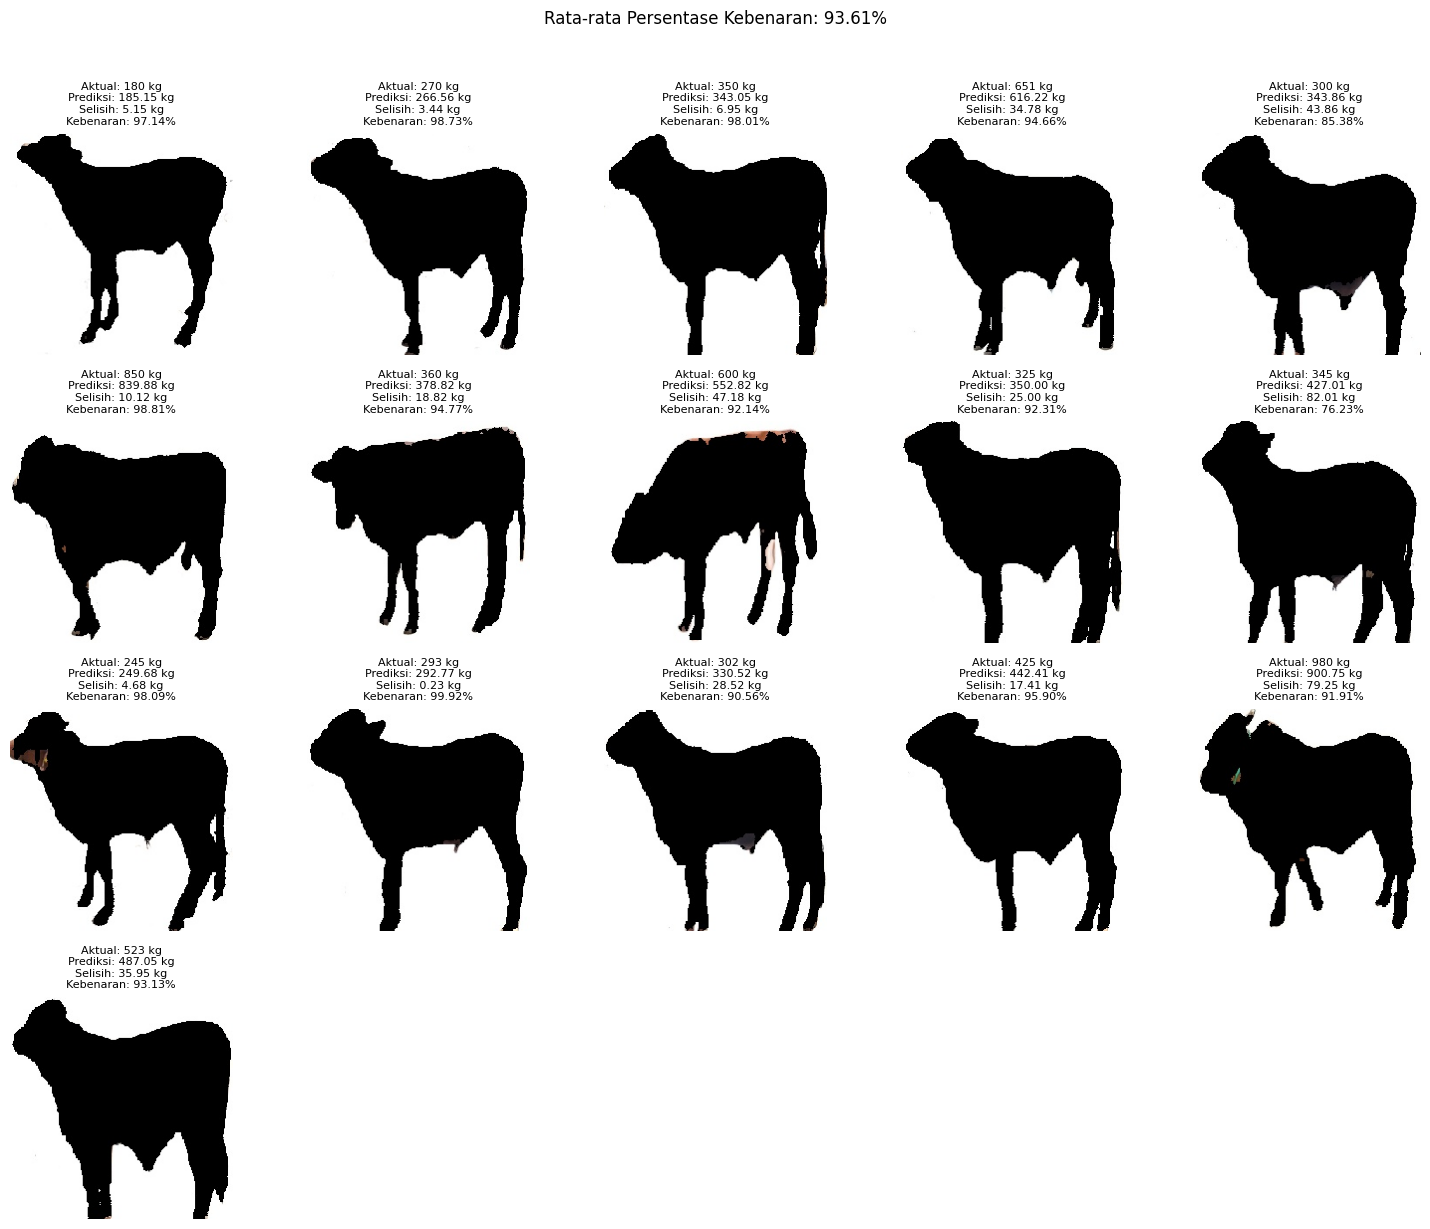

In [ ]:
import zipfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import math
import cv2

# Ekstrak file ZIP test
test_zip_path = '/content/dataset2.zip'
test_extract_path = '/content/'

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

print(f'File berhasil diekstrak ke {test_extract_path}')

segmentation_model = tf.keras.models.load_model('/content/segmentasi_model_unet_best.h5')

# Folder dataset
test_image_dir = '/content/dataset2'
test_segmented_dir = '/content/dataset2_segmented'
os.makedirs(test_segmented_dir, exist_ok=True)

SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH = 256, 256
PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH = 224, 224

def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SEGMENTATION_IMG_WIDTH, SEGMENTATION_IMG_HEIGHT)) / 255.0
    image_input = np.expand_dims(image, axis=0)
    pred_mask = segmentation_model.predict(image_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    segmented_image = image * np.expand_dims(pred_mask[:, :, 0], axis=-1)
    return segmented_image

images = []
labels = []

for filename in os.listdir(test_image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_image_dir, filename)
        segmented_image = segment_image(img_path)
        segmented_path = os.path.join(test_segmented_dir, filename)
        cv2.imwrite(segmented_path, cv2.cvtColor((segmented_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

        img_array = img_to_array(load_img(segmented_path, target_size=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH))) / 255.0
        label = int(filename.split('.')[0])

        images.append(img_array)
        labels.append(label)

X = np.array(images)
y = np.array(labels)

# Load model prediksi bobot sapi
best_model = tf.keras.models.load_model('best_model.h5')
prediksi_bobot = best_model.predict(X)
selisih = np.abs(y - prediksi_bobot.flatten())
persentase_kebenaran = 100 * (1 - selisih / y)
rata_rata_persentase = np.mean(persentase_kebenaran)

num_images = len(X)
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 3, rows * 3))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(f"Aktual: {y[i]} kg\nPrediksi: {prediksi_bobot[i][0]:.2f} kg\nSelisih: {selisih[i]:.2f} kg\nKebenaran: {persentase_kebenaran[i]:.2f}%", fontsize=8, color='black')

plt.suptitle(f"Rata-rata Persentase Kebenaran: {rata_rata_persentase:.2f}%", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

File berhasil diekstrak ke /content/


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


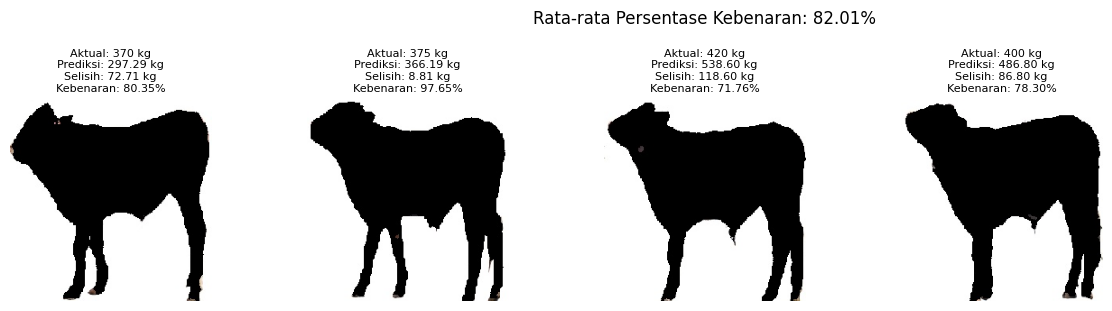

In [ ]:
import zipfile
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import math
import cv2

# Ekstrak file ZIP test
test_zip_path = '/content/test.zip'
test_extract_path = '/content/'

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

print(f'File berhasil diekstrak ke {test_extract_path}')

# Load model segmentasi
segmentation_model = tf.keras.models.load_model('/content/segmentasi_model_unet_best.h5')

# Folder dataset
test_image_dir = '/content/test'
test_segmented_dir = '/content/test_segmented'
os.makedirs(test_segmented_dir, exist_ok=True)

SEGMENTATION_IMG_HEIGHT, SEGMENTATION_IMG_WIDTH = 256, 256
PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH = 224, 224

def segment_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (SEGMENTATION_IMG_WIDTH, SEGMENTATION_IMG_HEIGHT)) / 255.0
    image_input = np.expand_dims(image, axis=0)
    pred_mask = segmentation_model.predict(image_input)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    segmented_image = image * np.expand_dims(pred_mask[:, :, 0], axis=-1)
    return segmented_image

images = []
labels = []

for filename in os.listdir(test_image_dir):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_image_dir, filename)
        segmented_image = segment_image(img_path)
        segmented_path = os.path.join(test_segmented_dir, filename)
        cv2.imwrite(segmented_path, cv2.cvtColor((segmented_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

        img_array = img_to_array(load_img(segmented_path, target_size=(PREDICTION_IMG_HEIGHT, PREDICTION_IMG_WIDTH))) / 255.0
        label = int(filename.split('.')[0])

        images.append(img_array)
        labels.append(label)

X = np.array(images)
y = np.array(labels)

# Load model prediksi bobot sapi
best_model = tf.keras.models.load_model('best_model.h5')
prediksi_bobot = best_model.predict(X)
selisih = np.abs(y - prediksi_bobot.flatten())
persentase_kebenaran = 100 * (1 - selisih / y)
rata_rata_persentase = np.mean(persentase_kebenaran)

num_images = len(X)
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 3, rows * 3))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(f"Aktual: {y[i]} kg\nPrediksi: {prediksi_bobot[i][0]:.2f} kg\nSelisih: {selisih[i]:.2f} kg\nKebenaran: {persentase_kebenaran[i]:.2f}%", fontsize=8, color='black')

plt.suptitle(f"Rata-rata Persentase Kebenaran: {rata_rata_persentase:.2f}%", fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

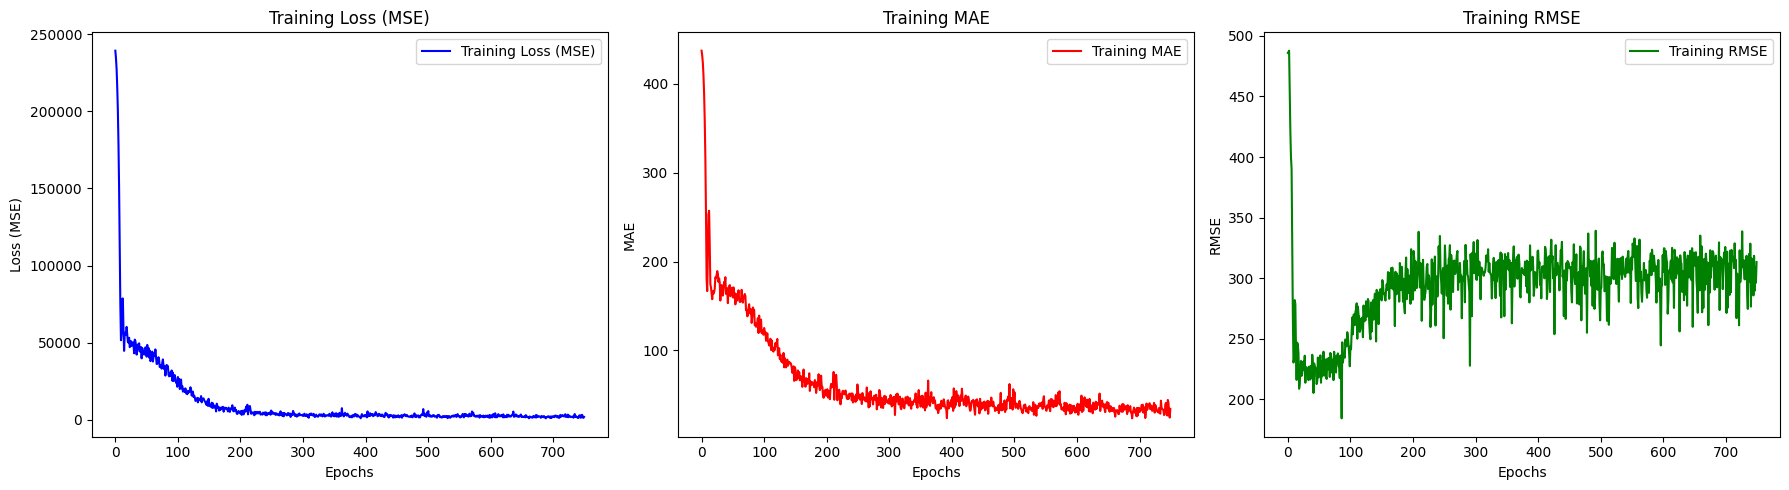

In [ ]:
plt.figure(figsize=(18, 5))

# Plot Loss (MSE)
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss (MSE)')
plt.legend()

# Plot Mean Absolute Error (MAE)
plt.subplot(1, 3, 2)
plt.plot(history.history['mae'], label='Training MAE', color='red')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training MAE')
plt.legend()

# Plot Root Mean Squared Error (RMSE)
plt.subplot(1, 3, 3)
plt.plot(history.history['rmse'], label='Training RMSE', color='green')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training RMSE')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Ambil nilai MAE dan RMSE dari history
mae_values = history.history['mae']
rmse_values = history.history['rmse']

min_mae_index = mae_values.index(min(mae_values))

min_mae = mae_values[min_mae_index]
corresponding_rmse = rmse_values[min_mae_index]

print(f"MAE terkecil: {min_mae:.4f} pada epoch {min_mae_index + 1}")
print(f"RMSE pada epoch yang sama: {corresponding_rmse:.4f}")

MAE terkecil: 23.4105 pada epoch 689
RMSE pada epoch yang sama: 303.8645
